In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Import Data**

In [15]:
# Linked Birth Infant Death Records 2017-2018
birth_deaths = pd.read_fwf("./data/birth.txt")

# Physicians and Surgeons by race/ethnicity and practice
physicians = pd.read_csv("./data/physicians.csv")

In [14]:
print("birth_deaths:", len(birth_deaths), "physicians:", len(physicians))

birth_deaths: 77 physicians: 892


In [52]:
physicians.head(10)

,Month,Year,Primary Practice County,Race/Ethnicity,Count of Licensees
0,March,2016,Alameda,African-American/Black/African,148
1,March,2016,Alameda,American Indian/ Native America,6
2,March,2016,Alameda,Asian - Cambodian,1
3,March,2016,Alameda,Asian - Chinese,284
4,March,2016,Alameda,Asian - Indian,273
5,March,2016,Alameda,Asian - Indonesian,2
6,March,2016,Alameda,Asian - Japanese,20
7,March,2016,Alameda,Asian - Korean,41
8,March,2016,Alameda,Asian - Other Asian,34
9,March,2016,Alameda,Asian - Pakistani,15


<AxesSubplot:xlabel='Race/Ethnicity', ylabel='Count of Licensees'>

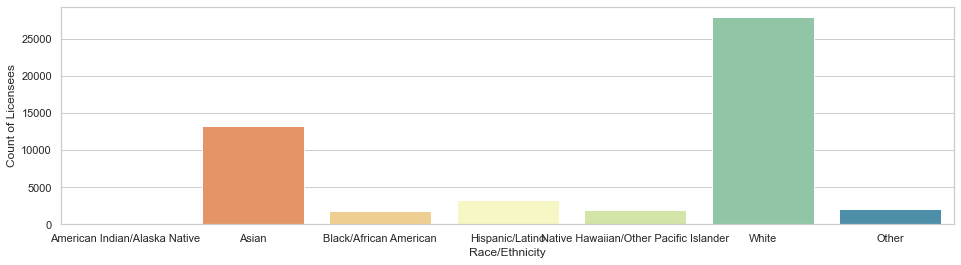

In [55]:
# Simplify Race/Ethnicity into ethnic groups (https://grants.nih.gov/grants/guide/notice-files/not-od-15-089.html)
ethnic_groups = {
    "American Indian/Alaska Native": 0,
    "Asian": 0,
    "Black/African American": 0,
    "Hispanic/Latino": 0,
    "Native Hawaiian/Other Pacific Islander": 0,
    "White": 0,
    "Other": 0
}

for index, row in physicians.iterrows():
    if 'White' in row['Race/Ethnicity']:
        ethnic_groups['White'] += row['Count of Licensees']
    elif 'Latino' in row['Race/Ethnicity'] or 'Hispanic' in row['Race/Ethnicity']:
        ethnic_groups['Hispanic/Latino'] += row['Count of Licensees']
    elif 'African-American' in row['Race/Ethnicity'] or 'Black' in row['Race/Ethnicity']:
        ethnic_groups['Black/African American'] += row['Count of Licensees']
    elif 'Hawaiian' in row['Race/Ethnicity']:
        ethnic_groups['Native Hawaiian/Other Pacific Islander'] += row['Count of Licensees']
    elif 'Asian' in row['Race/Ethnicity'] or 'Taiwanese' in row['Race/Ethnicity'] or 'Singaporean' in row['Race/Ethnicity'] or 'Malaysian' in row['Race/Ethnicity']:
        ethnic_groups['Asian'] += row['Count of Licensees']
    elif 'Native America' in row['Race/Ethnicity']:
        ethnic_groups['American Indian/Alaska Native'] += row['Count of Licensees']
    else:
        ethnic_groups['Other'] += row['Count of Licensees']
    
columns = ['Race/Ethnicity', 'Count of Licensees']

data = []
for race, count in ethnic_groups.items():
    data.append([race, count])

physicians_ethnic_groups = pd.DataFrame(data, columns=columns)

# Plot!
sns.set(style="whitegrid")

plt.figure(1, figsize=(16,4))
sns.barplot(x='Race/Ethnicity',y='Count of Licensees', data=physicians_ethnic_groups, palette='Spectral')